In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
#conda install -c conda-forge ipywidgets
#conda install nodejs
#jupyter labextension install @jupyter-widgets/jupyterlab-manager

import os, shutil, subprocess
import pandas as pd
from ipywidgets import widgets
from ipywidgets import interact
from IPython.display import display
from math import floor
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('ggplot')

import numpy as np

%matplotlib notebook

# Set atoms for colvars

In [2]:

pdbFile = "./setup/decarboxylase.0.pdb"
psfFile = "./setup/decarboxylase.0.psf"

dcdFile = "./SMD_Data/min_smd.dcd"
xstFile = "./SMD_Data/min_smd.xst"

atomDistList = []

### Decarboxylase

atomDistList.append( (3311,3312,"OMP C6 <-> OMP C7") )
atomDistList.append( (3311,1020,"OMP C6 <-> Lys61 HZ1") )
atomDistList.append( (3314,980,"OMP OA <-> Asp59 OD2") )
atomDistList.append( (3313,979,"OMP OB <-> Asp59 OD1") )

atomDistList

[(3311, 3312, 'OMP C6 <-> OMP C7'),
 (3311, 1020, 'OMP C6 <-> Lys61 HZ1'),
 (3314, 980, 'OMP OA <-> Asp59 OD2'),
 (3313, 979, 'OMP OB <-> Asp59 OD1')]

# Set paths for tools used along the tutorial

In [3]:

#catdcdPath = "catdcd"

catdcdPath = "/Applications/VMD\ 1.9.4.app/Contents/vmd/plugins/MACOSXX86/bin/catdcd5.2/catdcd"


# Create TCL that loads DCD and calculates colvar values over trajectory to save in a CSV.

In [4]:
tclOut = open("./tmp/calc_distances.tcl","w")

# Creates strings that will be written to a TCL file, and executed by VMD
fileStrings = []

# Loads PSF and DCD files
fileStrings.append("set molID [ mol new " + psfFile + "] \n")
#fileStrings.append("mol addfile " + pdbFile + "\n")
fileStrings.append("mol addfile " + dcdFile + " waitfor all molid $molID \n")

# Gets number of frames and opens CSV output file.
fileStrings.append("""

set numFrames [molinfo $molID get numframes]

puts \"Number of frames: $numFrames\"

set fpCVDat [open "./tmp/cv_data.csv" w]

""")

# Sets the distance tracking for the chosen pairs of atoms, and create variables for plotting and analysis.
headerStr = ""
distStr = ""
keyNameDic = {}
measureStrings = []
for indx in range(len(atomDistList)):
    
    distSel = atomDistList[indx]
    measureStrings.append("\t# Distance " + str(indx) + ": " + str(distSel[2]) + "\n")
    measureStrings.append("\tset dist" + str(indx) + " [ measure bond {" + str(distSel[0]) + " " + \
                          str(distSel[1]) + "} molid $molID ] \n\n")
    
    if indx > 0:
        comma = ","
    else:
        comma = ""
    distStr += comma + "$dist" + str(indx)
    headerStr += comma + "dist" + str(indx)
    
    keyNameDic["dist"+str(indx)] = str(distSel[2])


# Writes header to CSV file
fileStrings.append("puts $fpCVDat \"" + headerStr + "\" \n")

# Initiates loop for ColVar tracking.
fileStrings.append("""

for {set frame 0} {$frame < $numFrames} {incr frame} { 

    animate goto $frame
    
""")

# Adds lines that calculate atom distances.
fileStrings += measureStrings

# Writes distance data to CSV file
fileStrings.append("\tputs $fpCVDat \"" + distStr + "\" \n")

# Ends loop and closes CSV file
fileStrings.append("""
}

close $fpCVDat 

""" )

tclOut.writelines(fileStrings)

tclOut.close()

# Run VMD with TCL script

In [5]:
%%bash

/Applications/VMD\ 1.9.4.app/Contents/Resources/VMD.app/Contents/MacOS/vmd -dispdev text -e ./tmp/calc_distances.tcl
#vmd -dispdev text -e ./tmp/calc_distances.tcl

Info) VMD for MACOSXX86, version 1.9.4a8 (August 30, 2017)
Info) http://www.ks.uiuc.edu/Research/vmd/                         
Info) Email questions and bug reports to vmd@ks.uiuc.edu           
Info) Please include this reference in published work using VMD:   
Info)    Humphrey, W., Dalke, A. and Schulten, K., `VMD - Visual   
Info)    Molecular Dynamics', J. Molec. Graphics 1996, 14.1, 33-38.
Info) -------------------------------------------------------------
Info) Multithreading available, 8 CPUs detected.
Info) Dynamically loaded 2 plugins in directory:
Info) /Applications/VMD 1.9.4.app/Contents/vmd/plugins/MACOSXX86/molfile
after#0
psfplugin) Detected a Charmm PSF file
psfplugin) Detected a Charmm PSF EXTEnded file
Info) Using plugin psf for structure file ./setup/decarboxylase.0.psf
Info) Analyzing structure ...
Info)    Atoms: 48341
Info)    Bonds: 33354
Info)    Angles: 21065  Dihedrals: 8802  Impropers: 566  Cross-terms: 213
Info)    Bondtypes: 0  Angletypes: 0  Dihedraltypes

# Load CSV in Python for frame selection
### Explain Pandas
### Explain Melt/Cast

In [6]:
cvDat = pd.read_csv("./tmp/cv_data.csv")
numFrames = len(cvDat)
numColvars = len(cvDat.columns)

cvDatMelt = pd.melt(cvDat, var_name="colvar", value_name="Distance")

# Retreive data from selected frames

VBox(children=(HBox(children=(BoundedIntText(value=10, description='Number of Images:', max=32, min=3, style=DescriptionStyle(description_width='initial')), IntSlider(value=10, max=32, min=3, readout=False), Button(button_style='danger', description='Reset Selection', disabled=True, icon='eraser', style=ButtonStyle(), tooltip='Resets all selections and allows a new set of evenly spaced images to be created.'))), HBox(children=(ToggleButton(value=False, button_style='info', description='Add Intermediates', icon='square', tooltip='Adds intermediate images in regions of high variability. This will lock the number of evenly spaced images selected above.'), BoundedFloatText(value=0.3, description='Maximum delta:', disabled=True, style=DescriptionStyle(description_width='initial')), Button(button_style='warning', description='calculate', disabled=True, icon='retweet', style=ButtonStyle(), tooltip='(Re)Calculate intermediate images. This may take some time.')))))

<IPython.core.display.Javascript object>


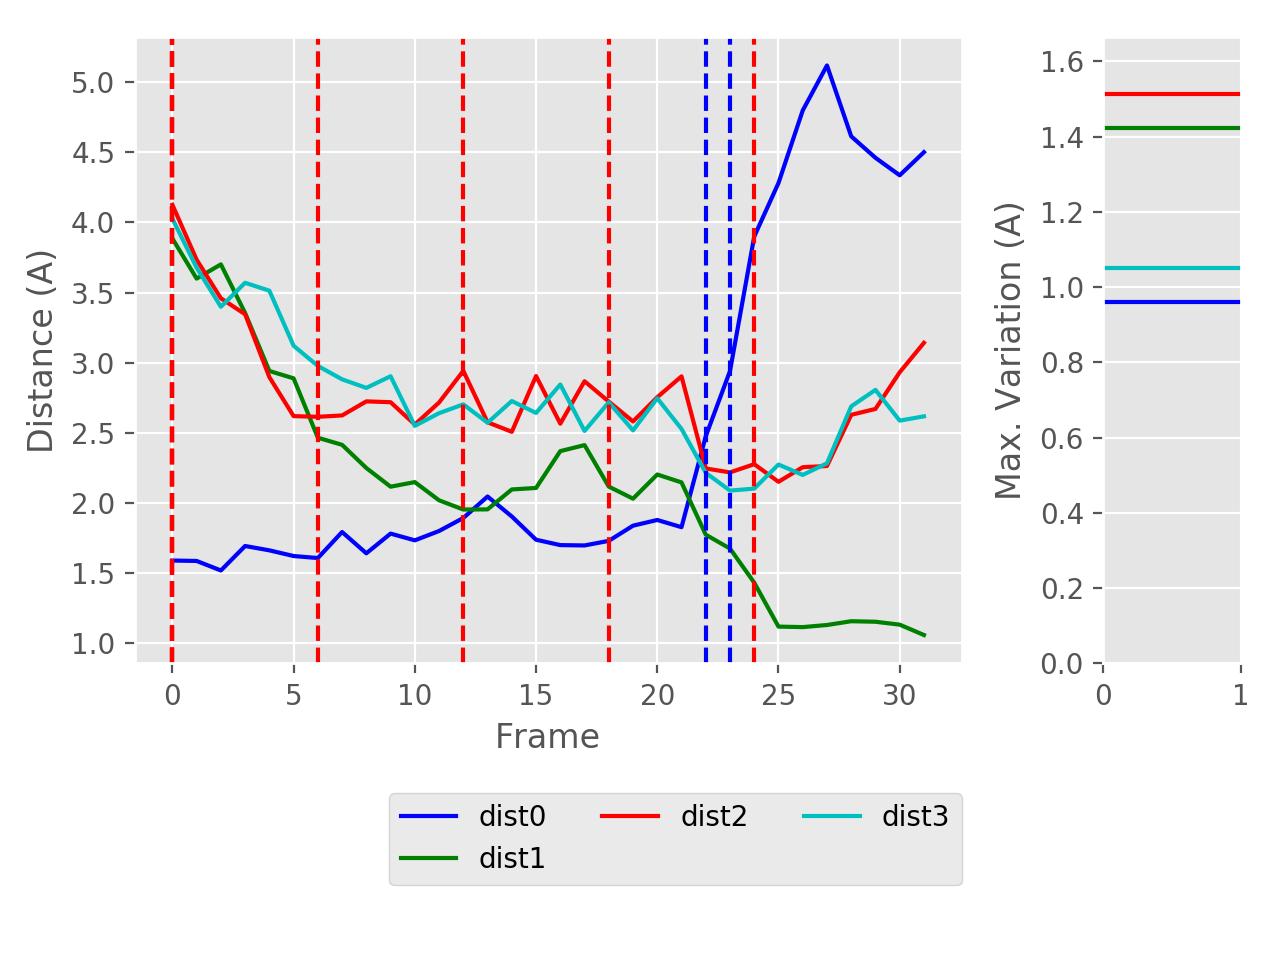

In [37]:
%matplotlib notebook
keyNameDic

# Initializes number of frames between images as one tenth of total frames, rounding down, and 
# making sure we have at least 1 (one) frame between images
def getImagesES(defaultNumImgs=10):
    imgStride = max(floor(numFrames/defaultNumImgs),1)
    return [x*imgStride for x in range(defaultNumImgs)]
imagesES = getImagesES(10)
numImgs = len(imagesES)

# Initializes list of intermediate images
imagesInt = []

# Sets widgets to select number of images
imagesText = widgets.BoundedIntText(
    value=numImgs, step=1, min=3, max=numFrames, 
    description="Number of Images:",
    style={'description_width': 'initial'}
)
imagesSlider = widgets.IntSlider(
    value=numImgs, step=1, readout=False, min=3, max=numFrames
)
resetSelB = widgets.Button(
    value=False,
    description='Reset Selection',
    disabled=True,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Resets all selections and allows a new set of evenly spaced images to be created.',
    icon='eraser'
)

mylink = widgets.jslink((imagesText, 'value'), (imagesSlider, 'value'))

hboxImgs = widgets.HBox([imagesText,imagesSlider,resetSelB])

# Sets widgets to automatically create images in high variability regions.
activateInterTB = widgets.ToggleButton(
    value=False,
    description='Add Intermediates',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Adds intermediate images in regions of high variability. \
This will lock the number of evenly spaced images selected above.',
    icon='square' # "check-square" vs "square"
)
defaultMaxDelta = 0.3
maxDeltaFT = widgets.BoundedFloatText(
    value=defaultMaxDelta, min=0, 
    description="Maximum delta:",
    style={'description_width': 'initial'},
    disabled=True
)
calcInterB = widgets.Button(
    value=False,
    description='calculate',
    disabled=True,
    button_style='warning', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='(Re)Calculate intermediate images. This may take some time.',
    icon='retweet'
)

hboxInter = widgets.HBox([activateInterTB, maxDeltaFT, calcInterB])


# Connects inputs
def toggle_intermediate(*args):
    # Activate user input
    
    # Change icon and Lock Image Selection.
    if activateInterTB.value:
        activateInterTB.icon = "check-square"
        maxDeltaFT.disabled = False
        calcInterB.disabled = False
        
        imagesText.disabled = True
        imagesSlider.disabled = True
        resetSelB.disabled = False
    else:
        activateInterTB.icon = "square"
        maxDeltaFT.disabled = True
        calcInterB.disabled = True
        
activateInterTB.observe(toggle_intermediate, "value")

# Displays both widgets
ui = widgets.VBox([hboxImgs, hboxInter])
display(ui)

# Build basic plot
xrange = np.arange(0, numFrames, 1)

#fig, (ax,ax2) = plt.subplots(1,2, )
fig = plt.figure()
gs = gridspec.GridSpec(2, 2, width_ratios=[6, 1], height_ratios=[7,1])
ax = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])
lax = plt.subplot(gs[1,0])

ax.set(xlabel='Frame', ylabel='Distance (A)')
ax1.set(xlabel='', ylabel='Max. Variation (A)')
ax1.set_ylim([0,1.5])

plt.show()

colors = ['b','g','r','c','m']
styles = ['-','-.','--',':']
styleTupls = []

def getStyleTupl(i):
    #if i > len(styleTupl):
    #    cIndx = i%len(colors)
    #    sIndx = int(i/len(colors))
    #    styleTupl.append((colors[cIndx],styles[sIndx]))
    cIndx = i%len(colors)
    sIndx = int(i/len(colors))
    return (colors[cIndx],styles[sIndx])

deltaLines = []
# Populate with selected colvar values
for key, grp in cvDatMelt.groupby(['colvar']):
    colStyl = getStyleTupl(len(styleTupls))
    styleTupls.append( colStyl )
    ax = grp.plot(ax=ax, kind='line', x=xrange, y='Distance', label=key, color=colStyl[0], style=colStyl[1])
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.20),
    #      ncol=3, fancybox=True, shadow=True)
    
    # Initializes points used for CV deltas
    deltaLines.append(ax1.axhline(y=0, label=key, color=colStyl[0], linestyle=colStyl[1]) )
    
    plt.draw()

h,l = ax.get_legend_handles_labels()
lax.legend(h,l, borderaxespad=0, ncol=3)
lax.axis("off")

ax.legend().set_visible(False)
ax1.legend().set_visible(False)

linesList = []

def update_imagesES(*args):
    imagesES = getImagesES(imagesText.value)
    update_plot(imagesES, imagesInt)

imagesText.observe(update_imagesES, 'value')

# Determines the maximum variation in ColVar values between sequential images.
def find_max_delta(imagesES, imagesInt):
    
    maxDeltaCV = [0]*len(cvDat.columns)
    
    allImgs = imagesES + imagesInt
    allImgs.sort()
    
    for indx in range(1,len(allImgs)):
        frameFin = allImgs[indx]
        frameIni = allImgs[indx -1]
        for colIndx in range(len(cvDat.columns)):
            delta = abs( cvDat.iloc[frameFin,colIndx] - cvDat.iloc[frameIni,colIndx] )
            if maxDeltaCV[colIndx] < delta:
                maxDeltaCV[colIndx] = delta
    
    return(maxDeltaCV)

def toggle_reset(*args):
    
    # Resets interface
    imagesText.disabled = False
    imagesSlider.disabled = False
    resetSelB.disabled = True
    
    activateInterTB.value = False
    toggle_intermediate()
    
    # Resets user input data
    maxDeltaFT.value = defaultMaxDelta
    imagesText.value = 10.0
    
    imagesES = getImagesES(imagesText.value)
    imagesInt = []
    
    # updates plot
    update_plot(imagesES, imagesInt)
    
resetSelB.on_click(toggle_reset)

def update_plot(imagesES, imagesInt):
    
    # Initialize Images on the plot
    
    lineIndx = 0
    for frame in imagesES:
        if lineIndx < len(linesList):
            linesList[lineIndx].set_xdata(frame)
            linesList[lineIndx].set_color("r")
        else:
            linesList.append( ax.axvline(x=frame, color="r", linestyle="--") )
        lineIndx += 1
    
    for frame in imagesInt:
        if lineIndx < len(linesList):
            linesList[lineIndx].set_xdata(frame)
            linesList[lineIndx].set_color("b")
        else:
            linesList.append( ax.axvline(x=frame, color="b", linestyle="--") )
        lineIndx += 1
    
    while lineIndx < len(linesList):
        linesList[lineIndx].set_xdata(imagesES[0])
        linesList[lineIndx].set_color("r")
        lineIndx += 1
    
    maxDeltaCV = find_max_delta(imagesES, imagesInt)
    
    index = 0
    for delta in maxDeltaCV:
        deltaLines[index].set_ydata(delta)
        index += 1
    
    ax1.set_ylim([0,max(maxDeltaCV)*1.1])
    
    fig.canvas.draw()

def calcIntermediates(imagesES):
    imagesInt = []
    
    # Gets current Maximum Delta
    maxD = maxDeltaFT.value
    
    # Loops over all Equally Spaced "gaps" 
    for indx in range(1,len(imagesES)):
        
        for colIndx in range(len(cvDat.columns)):
            
            frameFin = imagesES[indx]
            frameIni = imagesES[indx -1]
            
            checkRegion = True
            while checkRegion:
                
                # If the difference in this colvar is less than the maximum,
                # skip to the next.
                tmpdelta = abs( cvDat.iloc[frameFin,colIndx] - cvDat.iloc[frameIni,colIndx] )
                if tmpdelta <= maxD:
                    checkRegion = False
                    continue
                
                # Ungly trick to get the first frame, between two images, with a ColVar
                # variation langer than maxD.
                columnStr = str(cvDat.columns[colIndx])
                baseVal = cvDat.iloc[frameIni,colIndx]
                indxV = cvDat.iloc[frameIni:frameFin,:].query(columnStr + ' > ' + str(baseVal+maxD))
                
                # In case there is at least one frame where this ColVar has a variation greater than maxD
                if len(indxV) > 0 :
                    imagesInt.append(indxV.index[0])
                    frameIni = indxV.index[0]
                else:
                    # In case this ColVar does not have any variation granter than maxD
                    checkRegion = False
        
    return imagesInt

def toggle_calcInter(*args):
    imagesES = getImagesES(imagesText.value)
    imagesInt = calcIntermediates(imagesES)
    update_plot(imagesES, imagesInt)
calcInterB.on_click(toggle_calcInter)

update_plot(imagesES, imagesInt)

plt.tight_layout()
plt.show()

In [78]:
imgStride = max(floor(numFrames/imagesText.value),1)
imagesES = [x*imgStride for x in range(imagesText.value)]
numImgs = len(imagesES)

frames = imagesES + imagesInt
frames
imagesES
#imagesInt
#numImgs

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

# Creates DCD and XSC files to initiate String calculation

In [ ]:

setupPath = "String_eABF/setup/"

# Erases setup files if they exist. We start from scratch to avoid future errors.
if os.path.exists("String_eABF"):
    shutil.rmtree("String_eABF")
os.makedirs(setupPath)

print("Total selected frames:",len(frames))

stringFileList = []
stringIndex = 0
for frame in frames:
    
    # Creates a list of DCD files that will be used to write configuration files for the String.
    stringFileList.append("string_"+str(stringIndex)+".dcd")
    
    # Writes selected frames to DCD files for String input
    print("Writing frame " + str(frame) + " to file " + stringFileList[-1])
    command = catdcdPath + " -o " + setupPath + stringFileList[-1] + \
        " -first " + str(frame) + " -last " + str(frame+1) + " " + dcdFile
    subprocess.run(command, shell=True, check=True)
    
    # Exact frames from the XST file for String input
    sedFile = setupPath + "string_" + str(stringIndex) + ".xsc"
    sedLine = "sed -n " + str(frame + 1) + "p " + xstFile + " > " + sedFile 
    subprocess.run(sedLine, shell=True, check=True)
    
    stringIndex += 1


# Creates Configuration files to initiate String calculation

### We create configuration files for both String and eABF because we already have all the necessary data and parameters for both, but the eABF calculation will still need structural data that we will gather from the results of the String optimization.